In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor,RandomForestRegressor
import optuna

In [2]:
data = pd.read_csv('../input/tabular-playground-series-jan-2021/train.csv')
data.drop(columns='id',axis=1,inplace=True)
data.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483926,0.506877,0.553442,0.503713,7.905661
std,0.203976,0.228159,0.200770,0.233035,0.220701,0.217909,0.181096,0.216221,0.196685,0.201854,0.220082,0.218947,0.229730,0.208238,0.733071
min,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,0.484005,0.553209,0.551471,0.482880,0.451733,0.470988,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049025,0.977845,0.868506,10.267569


# Data Visualization and Cleaning

Let's take a look at the boxplot of each feature and target.

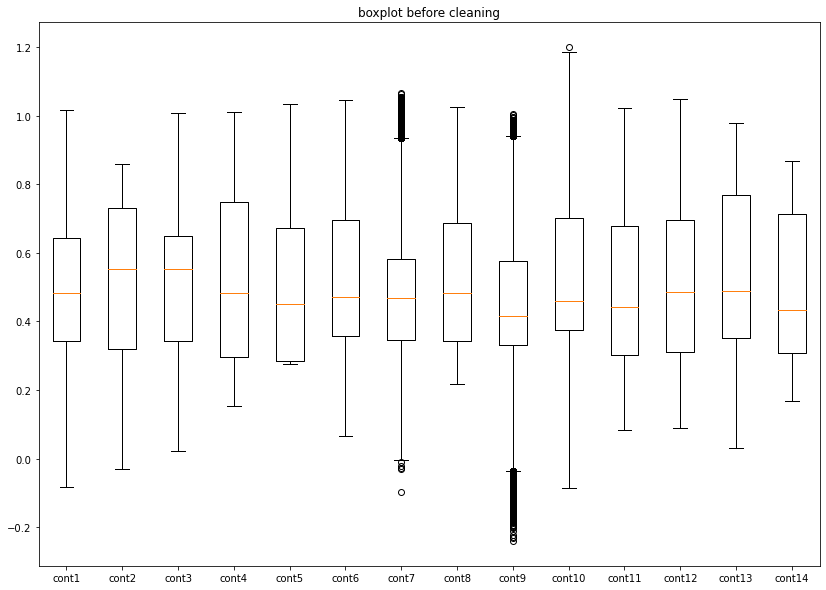

In [3]:
all_col_data = [data[col] for col in data.columns]
all_col_data.pop(-1)
fig,ax = plt.subplots(figsize=(14,10))
ax.boxplot(all_col_data)
ax.set_xticklabels(data.columns[:-1])
ax.set_title('boxplot before cleaning')
original_len = len(data)

There are some outliers in features 'cont7', 'cont9', 'cont10'

Text(0.5, 1.0, 'boxplot of target')

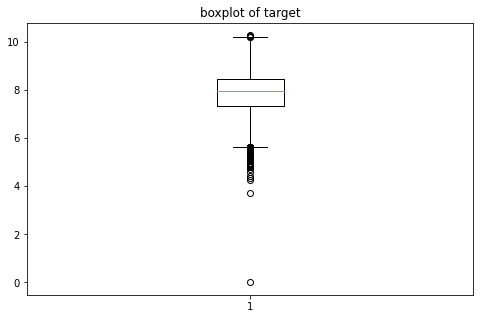

In [4]:
fig,ax = plt.subplots(figsize=(8,5))
ax.boxplot(data['target'])
ax.set_title('boxplot of target')

target=0 seems to be an extreme outlier.

In [5]:
data = data[data.target!=0]

**Attention: This cleaning method will lead to bad result.**

In [ ]:
IQR_dict = defaultdict(list)
for cont in ['cont7','cont9','cont10']:
    Q1 = data[cont].quantile(0.25)
    Q3 = data[cont].quantile(0.75)
    IQR = Q3 - Q1  
    IQR_dict[cont] = [Q1,Q3,IQR]
    
for key,value in IQR_dict.items():
    myfilter = (data[key] >= value[0] - 1.5 * value[2]) & (data[key] <= value[1] + 1.5 *value[2])
    data = data.loc[myfilter] 

In [ ]:
all_col_data = [data[col] for col in data.columns]
all_col_data.pop(-1)
fig,ax = plt.subplots(figsize=(14,10))
ax.boxplot(all_col_data)
ax.set_xticklabels(data.columns[:-1])
ax.set_title('boxplot after cleaning')
cleaned_len = len(data)

Clean data under the rule of 1.5*interquantile range

In [ ]:
print('%s rows of data is dropped'% (original_len-cleaned_len))

Let's also take a look at the box plot of target after cleaning.

Text(0.5, 1.0, 'boxplot of target')

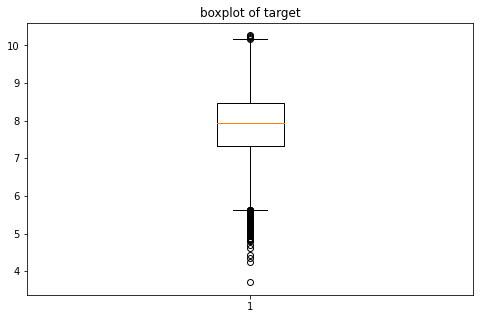

In [28]:
fig,ax = plt.subplots(figsize=(8,5))
ax.boxplot(data['target'])
ax.set_title('boxplot of target')

Check the correlation matrix.

Text(0.5, 1.0, 'correlation heatmap')

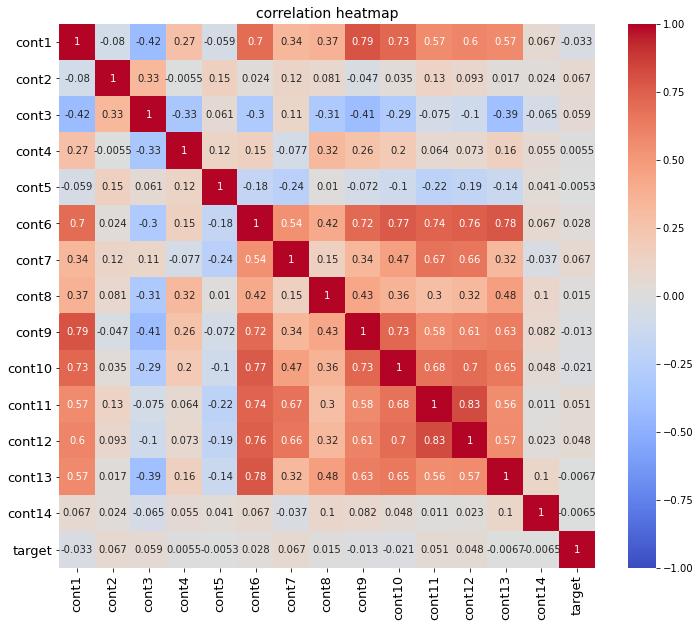

In [6]:
#x = data.drop(columns='target',axis=1)
corr = data.corr()
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr,ax=ax,vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.yticks(rotation=0,fontsize=13)
plt.xticks(rotation=90,fontsize=13)
ax.set_title('correlation heatmap',fontsize=14)

Features 'cont1', 'cont6'~'cont13' have relatively high correlation with each other. 

In [7]:
columns = np.full(shape=(corr.shape[0],), fill_value=True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
sel_columns = data.columns[columns]
data = data[sel_columns]
data.columns

Index(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8',
       'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'target'],
      dtype='object')

No column are dropped due to high absoulte correlation > 0.9

# Baseline Model

## XGBoost

In [8]:
def xgb_model_pipeline(data):
    #train_x,test_x,train_y,test_y = train_test_split(data,test_size=0.2,random_state=42)
    X = data.drop(columns='target',axis=1)
    y = data['target']

    ##Caculate E_cv (cross validation error)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    fold_error = []
    for fold,(train_idx,val_idx) in enumerate(kf.split(X)):
        train_X,val_X = X.iloc[train_idx,:],X.iloc[val_idx,:]
        train_y,val_y = y.iloc[train_idx],y.iloc[val_idx]
        
        print('Fold %s:'% (fold))
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=8,seed=42,verbosity=1)
        xgb_model.fit(train_X,train_y, eval_metric= 'rmse',
              eval_set=[(train_X,train_y),(val_X,val_y)], early_stopping_rounds=5,verbose=False)
        pred_y = xgb_model.predict(val_X)
        in_fold_rmse = np.sqrt(np.mean((val_y-pred_y)**2))
        print('Fold %s rmse: %s\n' % (fold,in_fold_rmse))
        fold_error.append(in_fold_rmse)
        
    oof_rmse = np.sum(fold_error)/len(fold_error)
    print('E_cv: %s' % (oof_rmse))

    ##Train on the whole training data
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=8,seed=42,verbosity=1)
    xgb_model.fit(X,y,verbose=False)
    
    ##Plot feature importance
    fig,ax = plt.subplots(figsize=(10,8))
    xgb.plot_importance(xgb_model, ax=ax, importance_type='gain')
    plt.yticks(fontsize=14)
    
    return xgb_model

Fold 0:
Fold 0 rmse: 0.6990047397705567

Fold 1:
Fold 1 rmse: 0.6985470944616992

Fold 2:
Fold 2 rmse: 0.7020975526615627

Fold 3:
Fold 3 rmse: 0.7020114652440551

Fold 4:
Fold 4 rmse: 0.7030180632422561

E_cv: 0.7009357830760259


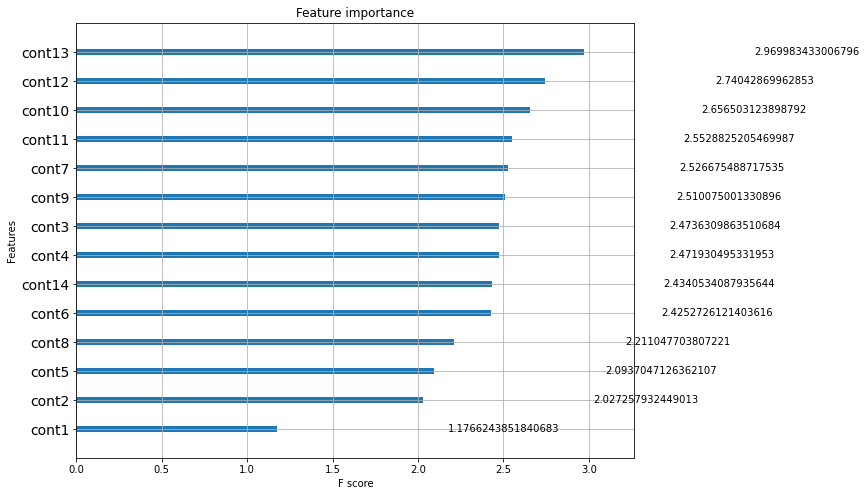

In [9]:
xgb_model = xgb_model_pipeline(data)

## LightGBM

In [22]:
def lightgbm_pipeline(data):
    X = data.drop(columns='target',axis=1)
    y = data['target']

    ##Caculate E_cv (cross validation error)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    fold_error = []
    for fold,(train_idx,val_idx) in enumerate(kf.split(X)):
        train_X,val_X = X.iloc[train_idx,:],X.iloc[val_idx,:]
        train_y,val_y = y.iloc[train_idx],y.iloc[val_idx]
        
        print('Fold %s:'% (fold))
        lgbm_model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, 
                                   max_depth=8,random_state=42,verbosity=-1)
        lgbm_model.fit(train_X,train_y, eval_metric= 'rmse',
              eval_set=[(val_X,val_y)], early_stopping_rounds=5,verbose=0)
        pred_y = lgbm_model.predict(val_X)
        in_fold_rmse = np.sqrt(np.mean((val_y-pred_y)**2))
        print('Fold %s rmse: %s\n' % (fold,in_fold_rmse))
        fold_error.append(in_fold_rmse)
        
    oof_rmse = np.sum(fold_error)/len(fold_error)
    print('E_cv: %s' % (oof_rmse))

    ##Train on the whole training data
    lgbm_model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, 
                               max_depth=8, random_state=42,verbosity=-1)
    lgbm_model.fit(X,y,verbose=0)
    
    ##Plot feature importance
    fig,ax = plt.subplots(figsize=(10,8))
    lgbm.plot_importance(lgbm_model, ax=ax, importance_type='gain')
    plt.yticks(fontsize=14)
    
    return lgbm_model

Fold 0:
Fold 0 rmse: 0.6987071073537097

Fold 1:
Fold 1 rmse: 0.6986731535385377

Fold 2:
Fold 2 rmse: 0.7010813963729011

Fold 3:
Fold 3 rmse: 0.7020610043272226

Fold 4:
Fold 4 rmse: 0.702192687569925

E_cv: 0.7005430698324593


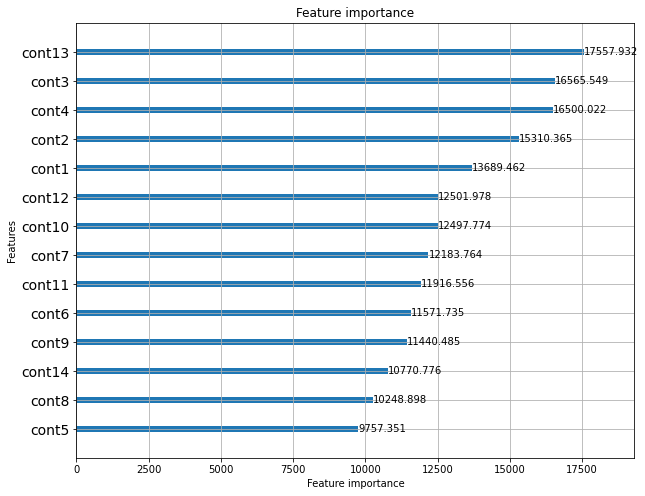

In [23]:
lgbm_model = lightgbm_pipeline(data)

LightGBM baseline model performs better than XGBoost baseline model. On public leaderboard(0.70140 vs 0.70587).

# Optuna

## Tune XGBoost

In [58]:
def xgb_oof(trial,data):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [250, 300, 350, 400, 450]),
        "eta": trial.suggest_loguniform("eta",1e-2,1e-1),
        "max_depth": trial.suggest_categorical("max_depth",[6,8,10,12]),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        "random_state": 42
    }
        
    X = data.drop(columns='target',axis=1)
    y = data['target']

    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    fold_error = []
    for fold,(train_idx,val_idx) in enumerate(kf.split(X)):
        train_X,val_X = X.iloc[train_idx,:],X.iloc[val_idx,:]
        train_y,val_y = y.iloc[train_idx],y.iloc[val_idx]
        
        xgb_model = XGBRegressor(**params)
        xgb_model.fit(train_X,train_y)
        pred_y = xgb_model.predict(val_X)
        in_fold_rmse = np.sqrt(np.mean((val_y-pred_y)**2))

        fold_error.append(in_fold_rmse)
        
    oof_rmse = np.sum(fold_error)/len(fold_error)
    return oof_rmse

In [59]:
def objective(trial):
    return xgb_oof(trial,data)

In [60]:
study = optuna.create_study(direction='minimize',study_name='XGBoost optimization')
study.optimize(objective, n_trials=10)

[I 2021-01-08 18:17:29,227] A new study created in memory with name: XGBoost optimization
[I 2021-01-08 18:22:42,987] Trial 0 finished with value: 0.7025522868571374 and parameters: {'n_estimators': 300, 'eta': 0.034728873814716746, 'max_depth': 6, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 5}. Best is trial 0 with value: 0.7025522868571374.
[I 2021-01-08 18:33:03,841] Trial 1 finished with value: 0.6988059826415675 and parameters: {'n_estimators': 450, 'eta': 0.025241948026570656, 'max_depth': 10, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 7}. Best is trial 1 with value: 0.6988059826415675.
[I 2021-01-08 18:49:50,782] Trial 2 finished with value: 0.7006754672244797 and parameters: {'n_estimators': 400, 'eta': 0.051231077777127154, 'max_depth': 12, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 5}. Best is trial 1 with value: 0.6988059826415675.
[I 2021-01-08 19:00:36,224] Trial 3 finished with value: 0.6995017656753797 and parame

In [61]:
study.best_params

{'n_estimators': 450,
 'eta': 0.025241948026570656,
 'max_depth': 10,
 'subsample': 0.6,
 'colsample_bytree': 0.6,
 'min_child_weight': 7}

In [62]:
best_xgb = XGBRegressor(**(study.best_params))
best_xgb.fit(data.drop(columns='target',axis=1),data['target'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.025241948026570656,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0252419487,
             max_delta_step=0, max_depth=10, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=450, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Tune LightGBM

In [51]:
def lgbm_oof(trial,data):
    params = {
        'num_leaves':trial.suggest_int('num_leaves',31,100),
        "n_estimators": trial.suggest_categorical("n_estimators", [250, 300, 350, 400, 450]),
        "eta": trial.suggest_loguniform("eta",1e-2,1e-1),
        "max_depth": trial.suggest_categorical("max_depth",[6,8,10,12]),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6,1,0.1),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6,1,0.1),
        "min_child_weight": trial.suggest_int("min_child_weight",5,11),
        'min_child_sample':trial.suggest_int('min_child_sample',20,50),
        "random_state": 42
    }
        
    X = data.drop(columns='target',axis=1)
    y = data['target']

    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    fold_error = []
    for fold,(train_idx,val_idx) in enumerate(kf.split(X)):
        train_X,val_X = X.iloc[train_idx,:],X.iloc[val_idx,:]
        train_y,val_y = y.iloc[train_idx],y.iloc[val_idx]
        
        lgbm_model = LGBMRegressor(**params)
        lgbm_model.fit(train_X,train_y)
        pred_y = lgbm_model.predict(val_X)
        in_fold_rmse = np.sqrt(np.mean((val_y-pred_y)**2))

        fold_error.append(in_fold_rmse)
        
    oof_rmse = np.sum(fold_error)/len(fold_error)
    return oof_rmse

In [52]:
def objective(trail):
    return lgbm_oof(trail,data)

In [53]:
study = optuna.create_study(direction='minimize',study_name='LGBM optimization')
study.optimize(objective, n_trials=20)

[I 2021-01-08 17:58:55,629] A new study created in memory with name: LGBM optimization
[I 2021-01-08 17:59:14,104] Trial 0 finished with value: 0.6993822234483547 and parameters: {'num_leaves': 33, 'n_estimators': 400, 'eta': 0.019698184278962305, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.6, 'min_child_weight': 8, 'min_child_sample': 34}. Best is trial 0 with value: 0.6993822234483547.
[I 2021-01-08 17:59:47,201] Trial 1 finished with value: 0.7004640807365279 and parameters: {'num_leaves': 85, 'n_estimators': 450, 'eta': 0.02720155432640898, 'max_depth': 12, 'subsample': 0.6, 'colsample_bytree': 0.9, 'min_child_weight': 7, 'min_child_sample': 47}. Best is trial 0 with value: 0.6993822234483547.
[I 2021-01-08 18:00:04,037] Trial 2 finished with value: 0.6999148288795599 and parameters: {'num_leaves': 88, 'n_estimators': 250, 'eta': 0.040093936190248765, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 11, 'min_child_sample': 22}. Best is tria

In [54]:
study.best_params

{'num_leaves': 42,
 'n_estimators': 400,
 'eta': 0.07349402647118564,
 'max_depth': 6,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'min_child_weight': 9,
 'min_child_sample': 32}

In [55]:
best_lgbm = LGBMRegressor(**(study.best_params))
best_lgbm.fit(data.drop(columns='target',axis=1),data['target'])

LGBMRegressor(colsample_bytree=0.6, eta=0.07349402647118564, max_depth=6,
              min_child_sample=32, min_child_weight=9, n_estimators=400,
              num_leaves=42)

# Ensemble two best models

In [67]:
best_xgb_param = {'n_estimators': 450,
                  'eta': 0.025241948026570656,
                  'max_depth': 10,
                  'subsample': 0.6,
                  'colsample_bytree': 0.6,
                  'min_child_weight': 7}

best_lgbm_param = {'num_leaves': 42,
                   'n_estimators': 400,
                   'eta': 0.07349402647118564,
                   'max_depth': 6,
                   'subsample': 1.0,
                   'colsample_bytree': 0.6,
                   'min_child_weight': 9,
                   'min_child_sample': 32}

In [73]:
def ensemble_pipeline(data,best_xgb,best_lgbm):
    X = data.drop(columns='target',axis=1)
    y = data['target']

    ##Caculate E_cv (cross validation error)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    fold_error = []
    for fold,(train_idx,val_idx) in enumerate(kf.split(X)):
        train_X,val_X = X.iloc[train_idx,:],X.iloc[val_idx,:]
        train_y,val_y = y.iloc[train_idx],y.iloc[val_idx]
        
        print('Fold %s:'% (fold))
        ensemble_model = StackingRegressor(estimators = 
                                           [('best_xgb',XGBRegressor(**best_xgb_param)),
                                            ('best_lgbm',LGBMRegressor(**best_lgbm_param))],
                                           final_estimator = 
                                           GradientBoostingRegressor(n_estimators=200,
                                                                 random_state=42))
        ensemble_model.fit(train_X,train_y)
        pred_y = ensemble_model.predict(val_X)
        in_fold_rmse = np.sqrt(np.mean((val_y-pred_y)**2))
        print('Fold %s rmse: %s\n' % (fold,in_fold_rmse))
        fold_error.append(in_fold_rmse)
        
    oof_rmse = np.sum(fold_error)/len(fold_error)
    print('E_cv: %s' % (oof_rmse))

    ##Train on the whole training data
    ensemble_model = StackingRegressor(estimators = 
                                        [('best_xgb',best_xgb),
                                        ('best_lgbm',best_lgbm)],
                                        final_estimator = 
                                        GradientBoostingRegressor(n_estimators=200,
                                                                 random_state=42))
    ensemble_model.fit(X,y)
    
    return ensemble_model

In [74]:
best_xgb = XGBRegressor(**best_xgb_param)
best_lgbm = LGBMRegressor(**best_lgbm_param)
ensemble_model = ensemble_pipeline(data,best_xgb,best_lgbm)

Fold 0:
Fold 0 rmse: 0.696713803029626

Fold 1:
Fold 1 rmse: 0.6958210822738264

Fold 2:
Fold 2 rmse: 0.6995071162078182

Fold 3:
Fold 3 rmse: 0.6997336565580182

Fold 4:
Fold 4 rmse: 0.7001618136303295

E_cv: 0.6983874943399238


# Submit Result

In [75]:
test = pd.read_csv('../input/tabular-playground-series-jan-2021/test.csv')
#pred_res = xgb_model.predict(test.loc[:,'cont1':])
#pred_res = best_xgb.predict(test.loc[:,'cont1':])
#pred_res = lgbm_model.predict(test.loc[:,'cont1':])
#pred_res = best_lgbm.predict(test.loc[:,'cont1':])
pred_res = ensemble_model.predict(test.loc[:,'cont1':])
submission = pd.DataFrame({'id':test.id,'target':pred_res})
submission.to_csv('submission.csv',index=False)

In [76]:
submission.head()

,id,target
0,0,7.950483
1,2,7.872279
2,6,7.943947
3,7,8.305977
4,10,8.186853
